# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result, QUBO_to_Ising

from networkx import Graph
from networkx.algorithms.approximation import min_weighted_dominating_set

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

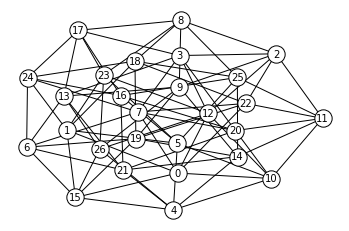

dict_values([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])


{'tag': 'Hamming(3,3)',
 'total_vertices': 27,
 'total_edges': 81,
 'max_edges': 6,
 'adjacency': [[7, 3],
  [24, 17],
  [0, 7],
  [15, 1],
  [13, 17],
  [0, 10],
  [6, 7],
  [19, 14],
  [15, 4],
  [26, 12],
  [4, 10],
  [4, 5],
  [0, 1],
  [18, 25],
  [4, 26],
  [6, 13],
  [14, 21],
  [4, 21],
  [20, 16],
  [25, 16],
  [20, 3],
  [26, 23],
  [3, 17],
  [15, 26],
  [12, 2],
  [19, 18],
  [13, 3],
  [15, 0],
  [7, 24],
  [1, 5],
  [22, 7],
  [26, 13],
  [9, 13],
  [9, 2],
  [14, 25],
  [11, 20],
  [10, 20],
  [12, 23],
  [11, 25],
  [2, 8],
  [9, 8],
  [23, 8],
  [19, 22],
  [15, 19],
  [14, 9],
  [5, 23],
  [16, 17],
  [7, 20],
  [21, 20],
  [23, 17],
  [12, 3],
  [0, 22],
  [19, 6],
  [1, 23],
  [26, 9],
  [0, 12],
  [2, 3],
  [22, 11],
  [10, 5],
  [5, 16],
  [24, 16],
  [1, 18],
  [15, 6],
  [22, 18],
  [10, 11],
  [11, 2],
  [6, 21],
  [6, 24],
  [21, 16],
  [18, 8],
  [25, 8],
  [21, 13],
  [22, 2],
  [10, 12],
  [5, 25],
  [1, 24],
  [18, 24],
  [4, 14],
  [8, 17],
  [14, 11],
  

In [2]:
# Define Adjacency matrix
tag = "Hamming(3,3)"
graph = {(0, 1), (1, 2)}
graph = gt.generate_hamming_graph(3, 3)
penalty = 1.1

directed = False
qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")

q_min = np.array(list(qubo.values())).min()

gt.get_plot(graph, directed=directed)
plt.show()
graph_params = graph_summary(tag, graph)
graph_params

In [ ]:
J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
print("Initial")
print(f"max(J) = {maxJ}")
print(f"max(h) = {maxh}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges\n")
fact = max([maxJ, maxh/2]) * 1.2
qubo = qubo / fact

J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
print("Rescaled")
print(f"max(J) = {maxJ}")
print(f"max(h) = {maxh}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges")

In [ ]:
#classical_search(qubo)

In [ ]:
# DWave settings
dwave_config = {
    "annealing_time": 200,  # integer microseconds [1, 2000]
    "answer_mode": "raw",
    "auto_scale": False,
    "num_reads": 1000,  # raw will dump out all results
    "num_spin_reversal_transforms": 0,  # ask Travis what this is
    "readout_thermalization": 0, # default 0
    "programming_thermalization": 1000, # default 1000
}
solver = "DW_2000Q_5"

experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, factor=fact, qubo=qubo)
experiment_params

In [ ]:
# Solve on DWave and push to database
sampler = DWaveSampler(solver=solver)
embed = EmbeddingComposite(sampler)
qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
result = embed.sample_qubo(qubo_dict, **dwave_config)
raw = result.to_pandas_dataframe()
data_params = data_summary(raw, graph_params, experiment_params)
result = insert_result(graph_params, experiment_params, data_params)
print(raw.sort_values("energy", ascending=True))